In [1]:
# Points projections using old framework
import pygplates
#import PyGPlates_PlateFrameRasters
import gplately
import sys
import os
import shutil
import xarray as xr
import glob
import pandas as pd

In [2]:
import re
# extract age from the mantlefraem grid files
# Optimized function that extracts the age and sorts the file paths
def sort_files_by_age(fpaths, match_string='Ma'):
    """
    This function extracts ages from file paths and sorts them (reverse/)chronologically.

    Parameters:
    fpaths: list of file paths
    match_string: the string to match before the age (default is 'Ma')

    Returns:
    Dictionary with the extracted age as the key and the sorted file paths as values
    """
    def extract_age(file_name):
        # Match both integer or float values followed by or preceded by 'Ma' (e.g., 10Ma or Ma10)
        match = re.search(r'(\d+(\.\d+)?)' + re.escape(match_string) + r'|(' + re.escape(match_string) + r'(\d+(\.\d+)?))', file_name)
        
        if match:
            # Check which part of the match to use
            if match.group(1):  # Age followed by 'Ma'
                age_str = match.group(1)
            elif match.group(3):  # 'Ma' followed by Age
                age_str = match.group(4)
            
            # Return as integer if no decimal part, otherwise return as float
            if '.' in age_str:
                return float(age_str)
            else:
                return int(age_str)
        else:
            
            return float('inf')  # Return inf if no match is found

    # Sort the file paths by the extracted age using a lambda function for extraction
    sorted_files = sorted(fpaths, key=lambda x: extract_age(x))
    
    # Return a dictionary with the age as the key and the file path as the value
    return {extract_age(file): file for file in sorted_files}

In [3]:
#xr.open_dataset('Scotese_paleogeography/Reconstruction/PALEOMAPGlobalPlateModel/paleogeography_reconstructed/Paleo-Elevation_0_504.nc').z.plot()
def flip_grid(geom):
    if geom.geom_type == 'MultiPoint':
        #print('Multipoint')
        flipped_points = [Point(pt.y, pt.x) for pt in geom.geoms]
        return MultiPoint(flipped_points)
        
    return geom  # skip if not MultiPoint
        

In [14]:
import geopandas as gpd
from shapely.validation import make_valid

#cobs= gpd.read_file('./cob_540.shp')
import gplately
from shapely.validation import make_valid

def label_position_reconstruct(row, age):
    
    model ='gld504'
    #scotese_datapath = r'.././Scotese_paleogeography/Reconstruction/PALEOMAPGlobalPlateModel'
    scotese_datapath = r'Reconstructions/Scotese_paleogeography/Reconstruction/PALEOMAPGlobalPlateModel'

    scotese_rot_file = f'{scotese_datapath}/PALEOMAP_PlateModel.rot'

    topology = gplately.pygplates.FeatureCollection(f'{scotese_datapath}/PALEOMAP_PlatePolygons.gpml')
    static_polyg= gplately.pygplates.FeatureCollection(f'{scotese_datapath}/PALEOMAP_PlatePolygons.gpml')
    
    model_labelrot = gplately.PlateReconstruction(scotese_rot_file, topology, static_polyg)
    multipolygon = row['geometry']
    coordinates = gpd.GeoSeries([multipolygon]).get_coordinates()
    # point = row.geometry.representative_point()
    # x, y = point.x, point.y  
    x = coordinates.x.mean()
    y = coordinates.y.mean()
    gpts = gplately.Points(model_labelrot, [x], [y])
    r_x, r_y = gpts.reconstruct(age, return_array=True)
    return r_x, r_y



def topology_merge_label(cobs_path):
    
    def map_plateid(val):
        for k, v in mapping.items():
            if str(val).startswith(k):
                return v
        return None

    mapping ={
        '101':'LAU',
        #'50': 'IN',
        '601':'NCC',
        #'602':'SC',
        '7703' : 'KAL',
        '701' : 'CON',
        '77144' : 'WAC',
        '803':'ANT',
        '802' : 'ANT',
        '206': 'SF',
        '2205': 'SF',
        '8011': 'AUS',
        '201': 'AMZ',
        #'26' :'AN',
        '302': 'BAL',
        '401' :'SIB',
        
        
    }
    cobs= gpd.read_file(cobs_path)
    
    cobs['LABEL'] = cobs['PLATEID1'].apply(lambda x: map_plateid(x) )
    cobs['geometry'] = cobs['geometry'].apply(make_valid)
    dissolved_cobs = cobs.dissolve(by='LABEL').reset_index()
    
    return dissolved_cobs

def merge_by_overlap(gdf, threshold=0.6):
    gdf = gdf.copy()
    
    # Fix invalid geometries
    gdf["geometry"] = gdf.geometry.buffer(0)

    merged = True
    while merged:
        merged = False
        n = len(gdf)
        merged_indices = set()
        merge_groups = []

        for i in range(n):
            if i in merged_indices:
                continue
            group = {i}
            for j in range(i + 1, n):
                if j in merged_indices:
                    continue

                # Catch topology errors safely
                try:
                    inter = gdf.geometry.iloc[i].intersection(gdf.geometry.iloc[j])
                    if inter.is_empty:
                        continue
                    a_i = gdf.geometry.iloc[i].area
                    a_j = gdf.geometry.iloc[j].area
                    if inter.area / a_i >= threshold or inter.area / a_j >= threshold:
                        group.add(j)
                except Exception as e:
                    print(f"Skipping pair ({i},{j}): {e}")
                    continue

            if len(group) > 1:
                merged_indices.update(group)
                merge_groups.append(group)

        if not merge_groups:
            break

        merged = True
        new_geoms = [unary_union([gdf.geometry.iloc[idx] for idx in group]) for group in merge_groups]
        remaining = [gdf.geometry.iloc[i] for i in range(n) if i not in merged_indices]
        gdf = gpd.GeoDataFrame(geometry=new_geoms + remaining, crs=gdf.crs).reset_index(drop=True)

    return gdf
    
# extract only exterior polygon of multipolygon cobs
def extract_outer(gdf_path, group_col):

    gdf = gpd.read_file(gdf_path)
    gdf_proj = gdf.to_crs(epsg=6933)

    largest_polys = []
    for group_val, group_df in gdf_proj.groupby(group_col):
        largest_poly = group_df.loc[group_df.geometry.area.idxmax()]
        largest_polys.append(largest_poly)

    # Return results back in original CRS
    result = gpd.GeoDataFrame(largest_polys, columns=gdf.columns, crs=gdf_proj.crs)
    return result.to_crs(gdf.crs)

# Rotate Dynamic Topography to present day
1. Rotate 540 and 220 dynamic topography to present day using gld504 reconstruction files
2. Since DT rate is already in the PlateFrame of reference; skipping the mantle frame to platframe for DT rate
3.  

In [5]:
import os
from optparse import OptionParser
from scipy.io import netcdf_file as netcdf
from scipy.interpolate import RectBivariateSpline
import rioxarray as rxr


def GetReconstructedMultipoint(reconstructed_feature_geometry):
        """Takes in reconstructed_feature_geometry and returns reconstructed lats, lon along with present day lats and lons

        -reconstructed_feature_geometry

    
    """

        # Get the reconstructed geometry and the associated present day geometry.
        reconstructed_multipoint_geometry = reconstructed_feature_geometry.get_reconstructed_geometry()
        # present_day_multipoint_geometry = pygplates.get_geometry_from_property_value(
        #         reconstructed_feature_geometry.get_property().get_value(),
        #         pygplates.MultiPointOnSphere)
    # Get the reconstructed feature's geometry
        reconstructed_geometry = reconstructed_multipoint_geometry
        present_day_multipoint_geometry = reconstructed_feature_geometry.get_present_day_geometry()
        # If the geometry is a MultiPointOnSphere, ensure you cast or handle the geometry accordingly
        if isinstance(present_day_multipoint_geometry, pygplates.MultiPointOnSphere):
            present_day_multipoint_geometry = present_day_multipoint_geometry
        else:
            # Handle other types of geometry if needed
            present_day_multipoint_geometry = None
            
        reconstructed_points = list(reconstructed_multipoint_geometry)
        present_day_points = list(present_day_multipoint_geometry)
        reconstructed_lat_points = []
        reconstructed_lon_points = []
        present_day_lat_lon_points = []
        # Iterate over the points in both multipoints (they should both have the same number of points).
        num_points = len(reconstructed_multipoint_geometry)
        # print 'num points in multipoint: %d' % num_points
        for point_index in range(0, num_points):
            # Index into the multipoint to get pygplates.PointOnSphere's.
            reconstructed_lat_lon_mp = pygplates.convert_point_on_sphere_to_lat_lon_point(reconstructed_points[point_index])
            reconstructed_lat_points.append(reconstructed_lat_lon_mp.get_latitude())
            reconstructed_lon_points.append(reconstructed_lat_lon_mp.get_longitude())
            present_day_lat_lon_mp = pygplates.convert_point_on_sphere_to_lat_lon_point(present_day_points[point_index])
            present_day_lat_lon_points.append((present_day_lat_lon_mp.get_latitude(), present_day_lat_lon_mp.get_longitude()))

        return (reconstructed_lon_points, reconstructed_lat_points, present_day_lat_lon_points)

def GeneratePlateReferenceFrameXYZ(rotation_model,reconstruction_time,multipoint_feature_collection,InputGridFile):
    

    try:
        
        # Try to open each NetCDF file
        data = xr.open_dataset(InputGridFile)
        if data.lon.min().values < 0:
            data = data.sortby('lon', ascending=True)  
            data = data.sortby('lat', ascending=True) 
            #print('I was in if loop')
            var='z'
        else:
            #print('I was in else loop')
            data['lon'] = data['lon'].where(data['lon'] <= 180, data['lon'] - 360)
            data = data.drop_duplicates(dim='lon')  # Drop duplicates based on longitude ('x')
            data = data.drop_duplicates(dim='lat') 
            data = data.sortby('lon', ascending=True)  # Sort by longitude
            data = data.sortby('lat', ascending=True)
            var='z'
    except OSError as e:
        # If an OSError occurs (e.g., due to an unknown file format), skip this file
        print(f"Skipping file due to error: {InputGridFile} | Error: {e}")
        return
    with open('output', 'w') as output_file:
        # Create an interpolation object for this grid
        f=RectBivariateSpline(data.lon.values,data.lat.values,data[var].values.T)
        
        # Reconstruct the multipoint features into a list of pygplates.ReconstructedFeatureGeometry's.
        reconstructed_feature_geometries = []
        pygplates.reconstruct(multipoint_feature_collection, rotation_model, reconstructed_feature_geometries, reconstruction_time)
        print ('num reconstructed multipoint geometries: %d' % len(reconstructed_feature_geometries))
        with open ('check', 'w') as check_file:
            for reconstructed_feature_geometry in reconstructed_feature_geometries:
                
                reconstructed_lon_points, reconstructed_lat_points, present_day_lat_lon_points = GetReconstructedMultipoint(reconstructed_feature_geometry)
                pdp_y, pdp_x = zip(*present_day_lat_lon_points)
                num_points =  len(present_day_lat_lon_points)
                
                # evaluate the current grid at the multipoint coordinates of the current feature
                gridZr = f.ev(reconstructed_lon_points, reconstructed_lat_points)
                #gridZr = f.ev(pdp_x, pdp_y)

                # append the interpolated points as lon,lat,Z triples to an ascii file
                for point_index in range(0, num_points):
                    pdp = present_day_lat_lon_points[point_index]
                    #output_file.write('%f %f %f %f\n' % (reconstructed_lon_points[point_index], reconstructed_lat_points[point_index], gridZr[point_index], reconstruction_time))
                    output_file.write('%f %f %f %f\n' % (pdp_x[point_index], pdp_y[point_index], gridZr[point_index], reconstruction_time))
                    check_file.write(f'{reconstruction_time} {reconstructed_lat_points[point_index]} {reconstructed_lon_points[point_index]}{present_day_lat_lon_points[point_index], point_index}\n')
            
def GeneratePlateReferenceFramesXYZ(rotation_model,raster_times,raster_filenames,multipoint_feature_collection,output_file_stem, output_dir):
    for reconstruction_time_index in range(0,len(raster_times)):
    
        reconstruction_time = raster_times[reconstruction_time_index]
        InputGridFile = raster_filenames[reconstruction_time_index]
        print ('time: %d Ma' % reconstruction_time)
        GeneratePlateReferenceFrameXYZ(rotation_model,reconstruction_time,multipoint_feature_collection,InputGridFile)
        cmd = f"gmt nearneighbor output -G{output_dir}reconstructed_%s_%d_to_0MA_504.nc -Rd -I0.125d -N1 -S0.75d -V" % (output_file_stem,reconstruction_time)
        
        os.system(cmd)
        cmd = "rm output check"
        os.system(cmd)
    

In [15]:


#---------------------------------------Load gld504 Reconstruction Model------------------------------------------------------------#
model='gld504'
input_rotation_filenames = [
        #f'.././Reconstructions/For_{model}/1000_0_rotfile_Merdith_et_al_slightly_changed_for_nnr_nico_mod.rot',
        #f'.././Reconstructions/For_{model}/NR_0Ma_1000Ma_for_gplates_combine.rot' 
        f'Reconstructions/For_{model}/1000_0_rotfile_Merdith_et_al_slightly_changed_for_nnr_nico_mod.rot',
        f'Reconstructions/For_{model}/NR_0Ma_1000Ma_for_gplates_combine.rot' 
]
static_polyg = gplately.pygplates.FeatureCollection('Reconstructions/shapes_static_polygons_Merdith_et_al.gpml')
cob= 'Reconstructions/For_gld504/COBfile_1000_0_combined_by_xianzhi.gpml'
gld504_reconstruction_model = gplately.PlateReconstruction(gplately.pygplates.RotationModel(input_rotation_filenames), cob, static_polyg)




input_multipoint_filename= f'Reconstructions/For_gld504/lat_lon_velocity_domain_720_1440_with_plate_IDs_with_ages_for_gld504.gpml',
for age in [220, 540]:
    # provide raster time and raster file as list
    # gld504_datasets = glob.glob(f'.././Model_data/{model}/Latitude*/*{age}*.grd')
    # gld504_datasets = glob.glob(f'.././Model_data/{model}/Latitude*/*{age}*.grd')
    
    gld504_datasets = glob.glob(f'Input_Data_Cluster/{model}/Latitude*/*{age}*.grd')
    gld504_datasets = glob.glob(f'Input_Data_Cluster/{model}/Latitude*/*{age}*.grd')
   
    output_dir = './EDF7_Data/'
    output_file_stem = f'{model}_DT'
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if os.path.exists(f'./EDF7_Data/reconstructed_{model}_DT_{age}_to_{0}MA.nc'):
        os.remove(f'./EDF7_Data/reconstructed_{model}_DT_{age}_to_{0}MA.nc')
        
    rotation_model = pygplates.RotationModel(input_rotation_filenames)

    file_registry = pygplates.FeatureCollectionFileFormatRegistry()
    print ('Reading multipoint data...')
    multipoint_feature_collection = file_registry.read(input_multipoint_filename)
    
        #PyGPlates_PlateFrameRasters.main()
    GeneratePlateReferenceFramesXYZ(rotation_model, [age], gld504_datasets, multipoint_feature_collection, output_file_stem, output_dir)
        
    
    

Reading multipoint data...
time: 220 Ma
num reconstructed multipoint geometries: 722


nearneighbor [INFORMATION]: Grid dimensions are n_columns = 2881, n_rows = 1441
nearneighbor [INFORMATION]: Number of sectors = 1, minimum number of filled sectors = 0
nearneighbor [INFORMATION]: Processing input table data
nearneighbor [INFORMATION]: Reading Data Table from file output
nearneighbor [INFORMATION]: Processed record     446505
nearneighbor [INFORMATION]: Gridded row       1441
nearneighbor [INFORMATION]: Writing grid to file ./EDF7_Data/reconstructed_gld504_DT_220_to_0MA_504.nc
nearneighbor [INFORMATION]: 1923378 nodes were assigned an average value
nearneighbor [INFORMATION]: 0 nodes failed sector criteria and 2228143 nodes had no neighbor points (all set to NaN)


Reading multipoint data...
time: 540 Ma
num reconstructed multipoint geometries: 429


nearneighbor [INFORMATION]: Grid dimensions are n_columns = 2881, n_rows = 1441
nearneighbor [INFORMATION]: Number of sectors = 1, minimum number of filled sectors = 0
nearneighbor [INFORMATION]: Processing input table data
nearneighbor [INFORMATION]: Reading Data Table from file output
nearneighbor [INFORMATION]: Processed record     287345
nearneighbor [INFORMATION]: Gridded row       1441
nearneighbor [INFORMATION]: Writing grid to file ./EDF7_Data/reconstructed_gld504_DT_540_to_0MA_504.nc
nearneighbor [INFORMATION]: 1292861 nodes were assigned an average value
nearneighbor [INFORMATION]: 0 nodes failed sector criteria and 2858660 nodes had no neighbor points (all set to NaN)


# Process cluster and dynamic topographic data of gld504 model
1. reconstruct DT and cluster to 540 Ma and 220 Ma  [ or any desired age] using gld504's reconstruction model
2. rotate previously processed paleoelevations using gld504's reconstruction model

In [7]:
def swap_clusters(nc,  rep_a, rep_b, var_to_replace="cluster",):
    # Extract the variable as a DataArray
    arr = nc

    # Step 1: Temporarily mark 0 as 100
    arr = xr.where(np.isfinite(arr) & (arr == rep_a), -1, arr)

    # Step 2: Replace 3 with 0
    arr = xr.where(np.isfinite(arr) & (arr == rep_b), rep_a, arr)

    # Step 3: Replace temporary 100 (originally 0) with -1
    arr = xr.where(np.isfinite(arr) & (arr == -1), rep_b, arr)

    # Return a new dataset with the updated variable
    return arr

clusters_ =2
if clusters_==5:
    
    mapping ={
        'gld421' : {0:1, 1:3, 3:4},
        'gld428' : {0:1, 1:3, 2:4},
        'gld431' : {0:1, 1:3, 2:4, 3:4},
        'gld434' : {0:1, 1:3, 3:4},
        'gld486' : {0:4,0:1, 2:3 },
        'gld504' : {0:4,  },
        
    }
    
    series_ =[0, clusters_ -1, 1]
    color_model= "+cC1,C2,C3,C4,C5"
    
elif clusters_==4:
    series_ =[0, clusters_ -1, 1]
    color_model= "+cC1,C2,C3,C4"
    mapping ={
        'gld421' : {0:3},
        'gld428' : {0:3,},
        'gld431' : {0:1,  2:3, 1:3},
        'gld434' : {0:1, 1:2, 2:3},
        'gld486' : {0:1, 1:3 },
        'gld504' : {0:1, 1:2, 2:3 },
        
    }
elif clusters_==2:
    series_ =[0, clusters_ -1, 1]
    color_model= "+cGU-F,GU-NF,"
    mapping ={
        'gld421' : {0:1},
        'gld428' : {0:1,},
        'gld431' : {0:1,},
        'gld434' : {0:1 },
        'gld486' : {0:1 },
        'gld504' : {0:1,},
        
    }
    
else:
    series_ =[0, clusters_ -1, 1]
    color_model= "+cC1,C2,C3"
    mapping ={
        'gld421' : {0:1, 1:2},
        'gld428' : {0:1, 1:2},
        'gld431' : {0:1, 1:2},
        'gld434' : {0:1, 1:2},
        'gld486' : {0:1, 1:2,},
        'gld504' : {0:1, 1:2},
        
    }
#xr.open_dataset(f'topologies_recon/cluster_{model}_420-920_540MA.nc')

# Rotate back to Mantleframe from Plateframe using gld504 rotfiles, features and static polygons

# Rotate Plateframe Rate to Mantle Frame of Reference
once rotated to Plateframe of reference, reconstructing back to mantle frame of reference using Scotese[or any model] works fine with gplately


In [16]:
import numpy as np
model ='gld504'
n_clusters = 2
cluster_datasets = [xr.open_dataset(f'ClusterAnalysis/cluster_gld504_420-920_{n_clusters}.nc').cluster,
                    xr.open_dataset(f'ClusterAnalysis/cluster_gld504_0-420_{n_clusters}.nc').cluster
                   ]                         
                          
ages =[540, 220]
windows =[ '420-920', '0-420']

#instantaneous_Dtrate= f'.././Model_data/{model}/{model}_PlateFrameRate{rate_age}Ma.nc'

# compute dt rate of change between 600 and 500 and 300- and 200
precambrain_change = (xr.open_dataset( f'Input_Data_Cluster/{model}/PlateFrameGrid/{model}PlateFrameGrid540.nc') -
                      xr.open_dataset( f'Input_Data_Cluster/{model}/PlateFrameGrid/{model}PlateFrameGrid600.nc')
                     ) /60
Pangea_change =  (xr.open_dataset( f'Input_Data_Cluster/{model}/PlateFrameGrid/{model}PlateFrameGrid220.nc') -
                      xr.open_dataset( f'Input_Data_Cluster/{model}/PlateFrameGrid/{model}PlateFrameGrid280.nc')
                     ) /60

longterm_dtrates =[precambrain_change.z, Pangea_change.z]

cob= 'Reconstructions/For_gld504/COBfile_1000_0_combined_by_xianzhi.gpml'

# gld504_reconstruction_model = gplately.PlateReconstruction(gplately.pygplates.RotationModel(input_rotation_filenames), cob, static_polyg)

scotese_datapath = r'Reconstructions/Scotese_paleogeography/Reconstruction/PALEOMAPGlobalPlateModel'
scotese_rot_file = f'{scotese_datapath}/PALEOMAP_PlateModel.rot'

topology = gplately.pygplates.FeatureCollection(f'{scotese_datapath}/PALEOMAP_PlatePolygons.gpml')

static_polyg= gplately.pygplates.FeatureCollection(f'{scotese_datapath}/PALEOMAP_PlatePolygons.gpml')
scotese_rotation_model=  gplately.PlateReconstruction(gplately.pygplates.RotationModel(scotese_rot_file), topology, static_polyg)
#scotese_model = pygplates.RotationModel(scotese_rot_file), topology_features=topology, static_polygons=static_polyg)


input_multipoint_filename = f'Reconstructions/Scotese_paleogeography/Reconstruction/PALEOMAPGlobalPlateModel/lat_lon_velocity_domain_720_1440_plate_IDs_and_ages.gpml'

for i,  (rate_age, cluster_age) in enumerate(zip([572,242], ages)):
    
    if model in ['gld504']:
        mapping_model =mapping[model]
        for rep_a, rep_b in mapping_model.items():
            data = swap_clusters(cluster_datasets[i], rep_a, rep_b)
    
    
    #-----------------Reconstruct Cluster--------------------------#
    
    raster_reconstruction = gplately.Raster(
        plate_reconstruction = scotese_rotation_model,
        data = cluster_datasets[i],
        extent ='global',
        origin ='lower'
    )
    
    reconstructed_raster= raster_reconstruction.reconstruct(time=cluster_age, partitioning_features =static_polyg)
    if os.path.exists(f'./EDF7_Data/cluster_gld504_{windows[i]}_{cluster_age}MA.nc'):
        os.remove(f'./EDF7_Data/cluster_gld504_{windows[i]}_{cluster_age}MA.nc')
    reconstructed_raster.save_to_netcdf4(f'./EDF7_Data/cluster_gld504_{windows[i]}_{cluster_age}MA.nc')

    # ----------------Reconstruct rate using gld504 reconstruction model----------------------#
    raster_reconstruction = gplately.Raster(
        plate_reconstruction = scotese_rotation_model,
        data =longterm_dtrates[i], #f'./Data_Fig4/reconstructed_{model}_DTrate_{rate_age}_to_0MA_504.nc',
        extent ='global',
        origin ='lower'
    )
    
    reconstructed_raster= raster_reconstruction.reconstruct(time=cluster_age, partitioning_features =static_polyg)
    if os.path.exists(f'./EDF7_Data/reconstructed_{model}_DTrate_{rate_age}_to_{cluster_age}MA_504.nc'):
        os.remove(f'./EDF7_Data/reconstructed_{model}_DTrate_{rate_age}_to_{cluster_age}MA_504.nc')
    reconstructed_raster.save_to_netcdf4(f'./EDF7_Data/reconstructed_{model}_DTrate_{rate_age}_to_{cluster_age}MA_504.nc')

     # ----------------Reconstruct DT amplitude using gld504 reconstruction model----------------------#
     # ----------------Reconstruct Paleoelevation using gld504 reconstruction model----------------------#
    raster_reconstruction = gplately.Raster(
        plate_reconstruction = scotese_rotation_model,
        data = f'./EDF7_Data/reconstructed_{model}_DT_{cluster_age}_to_0MA_504.nc',
        extent ='global',
        origin ='lower'
    )
    
    reconstructed_raster= raster_reconstruction.reconstruct(time=cluster_age, partitioning_features =static_polyg)
    if os.path.exists(f'./EDF7_Data/reconstructed_{model}_DT_{cluster_age}_to_{cluster_age}MA_504.nc'):
        os.remove(f'./EDF7_Data/reconstructed_{model}_DT_{cluster_age}_to_{cluster_age}MA_504.nc')
    reconstructed_raster.save_to_netcdf4(f'./EDF7_Data/reconstructed_{model}_DT_{cluster_age}_to_{cluster_age}MA_504.nc')

    #---------------------------Reconstruct COBs to the required age--------------------------------------#
    pygplates.reconstruct(cob, scotese_rot_file, f'./EDF7_Data/reconstructed_cob_{cluster_age}.shp', rate_age)
    pygplates.reconstruct(cob, scotese_rot_file, f'./EDF7_Data/reconstructed_cob_{cluster_age}.shp', cluster_age)
        
    



# Plot

[Session pygmt-session (865)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)
[Session pygmt-session (865)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)


[0, 1, 1] +cGU-F,GU-NF


[Session pygmt-session (1004)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)
[Session pygmt-session (1004)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)


[0, 1, 1] +cGU-HPP,GU-LPP


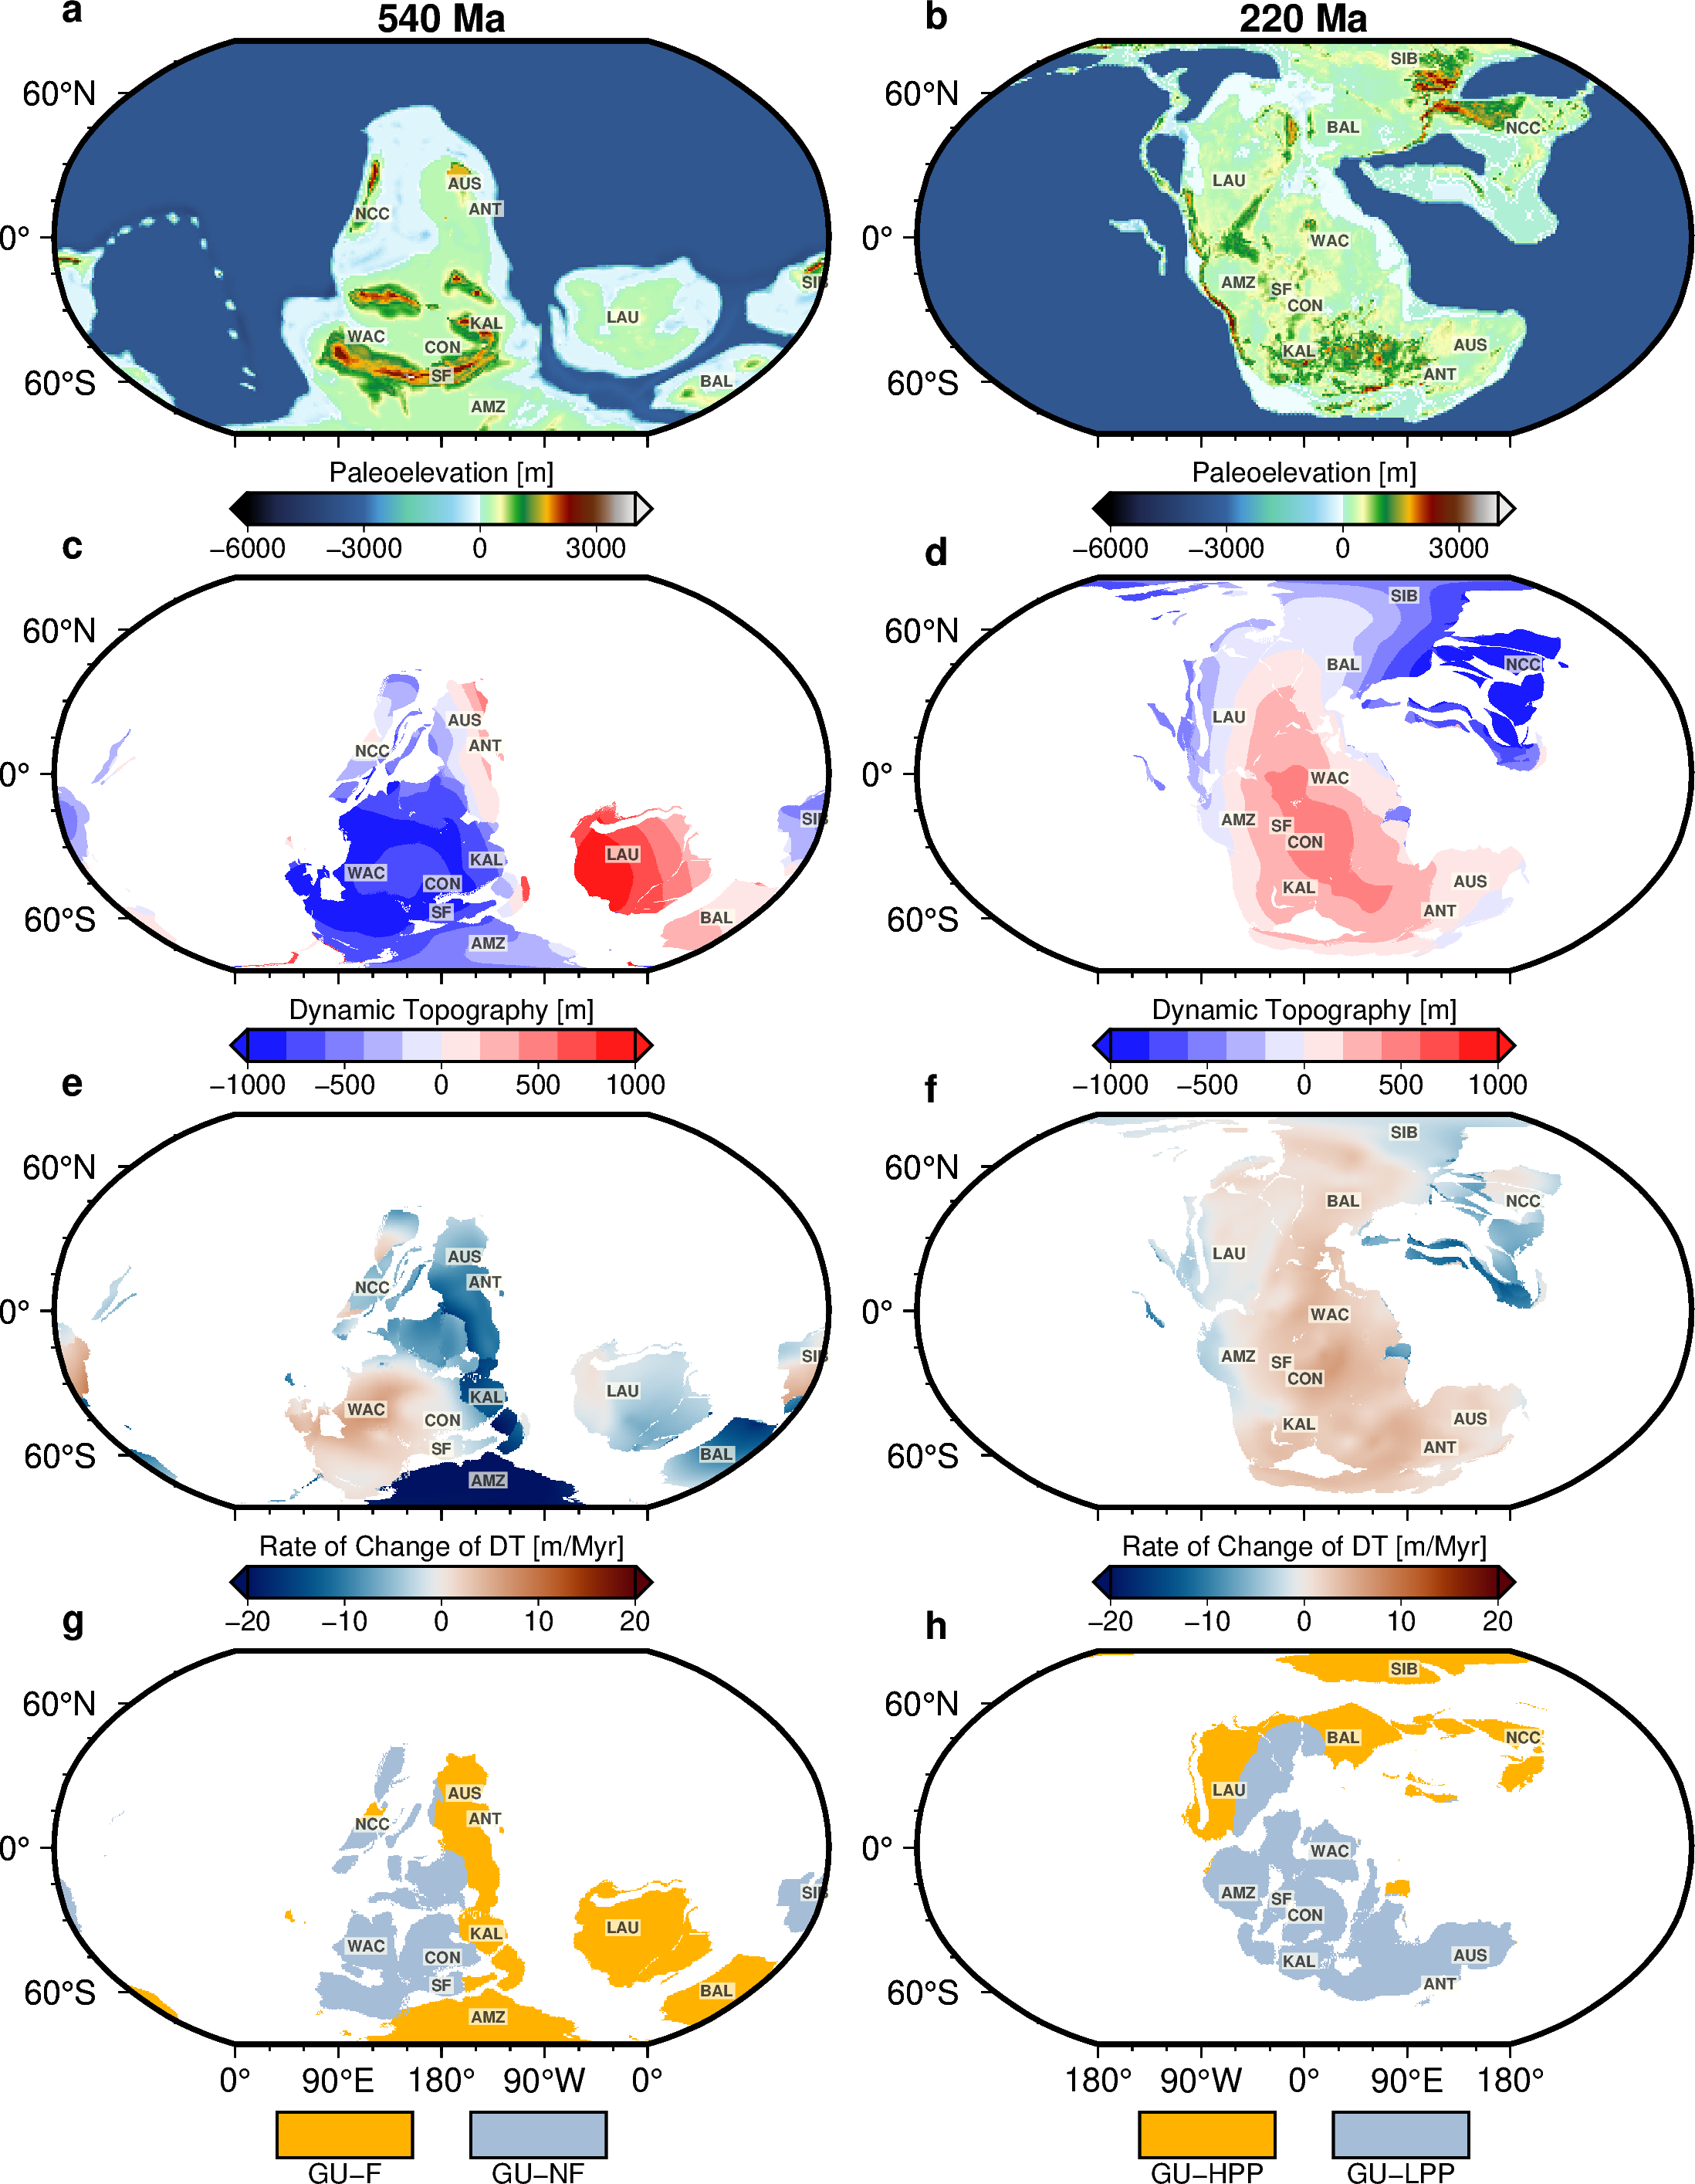

In [17]:
import pygmt

models = 'gld504'
projection = "N8.5c"
region ='d'
scotese_ages=[540,220]
rate_ages =[572,242]
windows = ['420-920', '0-420']


fig = pygmt.Figure()
pygmt.config(GMT_VERBOSE='q')
pygmt.config(MAP_HEADING_OFFSET="0p", MAP_TITLE_OFFSET="-12p",
             FONT_TITLE="12p,Helvetica-Bold,black", FONT_HEADING="16p,Helvetica-Bold,black", FONT_TAG="12p, Helvetica-Bold, black",)
# Define 1 row, 2 columns subplot
with fig.subplot(nrows=4, ncols=2, figsize=("18c", "23c"), frame=["Wstr"], margins=["0.2c", "0.2c"], autolabel ='a'):
    
    clearance =['s-0.5c', 'n-0.5c']
    for i, (rate_age, scotese_age) in enumerate(zip(rate_ages, scotese_ages)):
        cluster_fpath = f'./EDF7_Data/cluster_{model}_{windows[i]}_{scotese_age}MA.nc'
        gld504_DTrate_fpath = f'EDF7_Data/reconstructed_{model}_DTrate_{rate_age}_to_{scotese_age}MA_504.nc'
        gld504_DT_fpath = f'EDF7_Data/reconstructed_{model}_DT_{scotese_age}_to_{scotese_age}MA_504.nc'
        #NA_nc_fpath = f'topologies_recon/NA_{model}_{windows[i]}.nc'
        paleoelev=xr.open_dataset(glob.glob(f'Reconstructions/Scotese_paleogeography/Reconstruction/PALEOMAPGlobalPlateModel/Scotese_Wright_2018_Maps_1-88_1degX1deg_PaleoDEMS_nc_v2/*{scotese_age}Ma.nc')[0])

        dtrate_540 = xr.open_dataset(gld504_DTrate_fpath).z
        dt_540 = xr.open_dataset(gld504_DT_fpath).z
        cluster = xr.open_dataset(f'{cluster_fpath}')
        if i ==0:
            region='g'
        else:
            region ='d'
            
        with fig.set_panel(panel=[0,i], clearance =clearance):
    
            # dt_540['lon'] = ((dt_540['lon'] + 180) % 360) - 180
            # dt_540= dt_540.sortby('lon')
            #load data
           
            cluster=swap_clusters(cluster,  0, 1, var_to_replace="cluster",)
            if i ==0:
                color_model= "+cGU-F,GU-NF"
            else:
                color_model= "+cGU-HPP,GU-LPP"
            
            #NA_Nc = xr.open_dataset(NA_nc_fpath)
            
            #-----------------------------PaleoElevation Plot------------------------------------------#
            pygmt.makecpt(cmap ='gmt/earth', series =[-6000,4000])
            
            fig.grdimage(grid=paleoelev.z, cmap =True, projection=projection, region= region, nan_transparent="blue", frame=None)
            #fig.coast(shorelines="1/0.5p", region='d', projection=projection    )
            cobs = f'./EDF7_Data/reconstructed_cob_{scotese_age}.shp'
            
            #Plot paleocontinents labels
            outer_cob = extract_outer(f'./EDF7_Data/reconstructed_cob_{scotese_age}.shp', 'PLATEID1')
            #fig.plot(data=outer_cob, region=region, projection=projection, pen="0.07, white")
            cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
            #cobs_path = f'./topologies_recon/gld504/topology_boundaries_0.00Ma.shp'
            COBS = topology_merge_label(cobs_path)
            for _, row in COBS.iterrows():
                # Get a point that is guaranteed to be inside the polygon
                
                r_x, r_y = label_position_reconstruct(row, scotese_age)
                label = row["LABEL"] # or any label field you want
                if label=='ANC':
                    r_x = r_x -20
                    r_y= r_y+5
                #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                fig.text(x=r_x, y=r_y, text=label, font="5p,Helvetica-Bold,black",fill='ivory', transparency=30, justify="CM", region=region, projection=projection, verbose='q')
                        
            with pygmt.config( FONT_ANNOT_PRIMARY="16p", FONT_LABEL='16p', FONT_ANNOT='16p'):
                fig.colorbar(cmap=True, position="x4.25c/-1.65c+w4.25c/0.35c+jTC+h+e+ml", frame =[f'xa3000 +lPaleoelevation [m]',]) #'ya+lm']) 
            fig.basemap(region=region, projection=projection, frame= [f"Wrts+t{scotese_age} Ma",f"xaf", "yaf"])
            
           

        #-----------------------------------Dynamic Topgraphy Plot------------------------------------------#
        with fig.set_panel(panel=[1,i],clearance =clearance):    
            # plot dynamic topography
            #pygmt.makecpt(cmap="gmt/cyclic", series=[0, 3, 1], color_model= "+cC1,C2,C3,C4")
            series = [-1000, 1000,200] #[int(dt_540.values.min()), int(dt_540.values.max()), ] 
            pygmt.makecpt(cmap="matlab/polar",series=series, background=True)
            fig.grdimage(grid=dt_540, projection=projection, region= region, nan_transparent="+znan", cmap=True , frame=None)
            #fig.coast(shorelines="1/0.5p", region='d', projection=projection    )
            outer_cob = extract_outer(f'./EDF7_Data/reconstructed_cob_{age}.shp', 'PLATEID1')
            cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
            
            
            COBS = topology_merge_label(cobs_path )
            for _, row in COBS.iterrows():
                # Get a point that is guaranteed to be inside the polygon
                
                r_x, r_y = label_position_reconstruct(row,scotese_age)
                label = row["LABEL"] # or any label field you want
                if label=='ANC':
                    r_x = r_x -20
                    r_y= r_y+5
                #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                fig.text(x=r_x, y=r_y, text=label, font="5p,Helvetica-Bold,black",fill='ivory', transparency=30, justify="CM", region=region, projection=projection, verbose='q')
                        
            
            with pygmt.config( FONT_ANNOT_PRIMARY="16p", FONT_LABEL='16p', FONT_ANNOT='16p'):
                fig.colorbar(cmap=True, position="x4.25c/-1.65c+w4.25c/0.35+jTC+h+e+ml",frame =[f'xa500+lDynamic Topography [m]',]) #'ya+lm'])
                
            fig.basemap(region=region, projection=projection, frame= ["Wrts",f"xaf", "yaf"])
            
        #-----------------------------------Dynamic Topgraphy Rate Plot------------------------------------------#
        with fig.set_panel(panel=[2,i],clearance =clearance):    
            # plot dynamic topography
            series = [-20, 20] #[int(dt_540.values.min()), int(dt_540.values.max()), ] 
            pygmt.makecpt(cmap="SCM/vik",series=series, background=True)
            fig.grdimage(grid=dtrate_540, projection=projection, region= region, nan_transparent="+znan", cmap=True , frame=None)
            #fig.coast(shorelines="1/0.5p", region='d', projection=projection    )
            outer_cob = extract_outer(f'./EDF7_Data/reconstructed_cob_{scotese_age}.shp', 'PLATEID1')
            
            
            #plot paleocontinents
            cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
            COBS = topology_merge_label(cobs_path )
            for _, row in COBS.iterrows():
                # Get a point that is guaranteed to be inside the polygon
                
                r_x, r_y = label_position_reconstruct(row,scotese_age)
                label = row["LABEL"] # or any label field you want
                if label=='ANC':
                    r_x = r_x -20
                    r_y= r_y+5
                #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                fig.text(x=r_x, y=r_y, text=label, font="5p,Helvetica-Bold,black",fill='ivory', transparency=30, justify="CM", region=region, projection=projection, verbose='q')
                        
            
            with pygmt.config( FONT_ANNOT_PRIMARY="16p", FONT_LABEL='16p', FONT_ANNOT='16p'):
                fig.colorbar(cmap=True, position="x4.25c/-1.65c+w4.25c/0.35+jTC+h+e+ml",frame =[f'xa10+lRate of Change of DT [m/Myr]',]) #'ya+lm'])
                
            fig.basemap(region=region, projection=projection, frame= ["Wrts",f"xaf", "yaf"])
            
           

        #-------------------------------------cluster plot---------------------------------------#
        with fig.set_panel(panel=[3,i], clearance =clearance):     
            # plot cluster in frame c
            print(series_, color_model)
            pygmt.makecpt(cmap="#FFB300,#A6BDD7", series=series_, color_model= color_model)
            fig.grdimage(grid=cluster.z, projection=projection, region= region, nan_transparent="+znan", cmap=True , frame=None)
            
            #fig.coast(shorelines="1/0.5p", region='d', projection=projection    )
            outer_cob = extract_outer(f'./EDF7_Data/reconstructed_cob_{scotese_age}.shp', 'PLATEID1')
            
            #plot paleocontinents
            cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
           
            COBS = topology_merge_label(cobs_path )
            for _, row in COBS.iterrows():
                # Get a point that is guaranteed to be inside the polygon
                
                r_x, r_y = label_position_reconstruct(row,scotese_age)
                label = row["LABEL"] # or any label field you want
                if label=='ANC':
                    r_x = r_x -20
                    r_y= r_y+5
                #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                fig.text(x=r_x, y=r_y, text=label, font="5p,Helvetica-Bold,black",fill='ivory', transparency=30, justify="CM", region=region, projection=projection, verbose='q')
                        
            with pygmt.config( FONT_ANNOT_PRIMARY="16p", FONT_LABEL='16p', FONT_ANNOT='16p'):
                fig.colorbar(cmap=True, position="x4.25c/-1.75c+w4.25c/0.5c+jTC+h+e+ml")
            fig.basemap(region=region, projection=projection, frame= ["WrtS",f"xaf", "yaf"])
            

fig.savefig(f'./ExtendedDataFigures/EDF7_Paleoelev_DT_DTrate_cluster_540 and 220MA.pdf', dpi=600, resize='+s18.2c')

fig.show()

In [ ]:
# Rate of change [600-500] and [300-200]